# Get ICESat-2 data

###### Based on the Tutorial by Amy Steiker at ICESat-2 Hackweek, June 2019

In [16]:
import requests
import getpass
import socket
import json
import zipfile
import io
import math
import os
import shutil
import pprint
import time
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import fiona
import h5py
import re
import sys
from remote_fns import *
# To read KML files with geopandas, we will need to enable support in fiona (disabled by default)
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'
from shapely.geometry import Polygon, mapping
from shapely.geometry.polygon import orient
from statistics import mean
from requests.auth import HTTPBasicAuth

### Step 1) Input parameters:

-location:

    - Option 1 = input kml/shp/geojson
    - Option 2 = input bounding box coordinates

-temporal range: start and end date and time

-desired data set (ATL03, ATL06, etc)

-variables you want (coverage) - this is optional and I have not quite figured it out yet

-path to save data

-EarthData login info

In [2]:
##----------------------------##
##------ Spatial range -------##'
##----------------------------##'
subset_method = 2 #1 for loading in a shapefile, 2 for using a bounding box
if subset_method == 1:
    region_filepath = str('/Volumes/c3po/Research/shape_files/RBIS/RBIS.shp')
elif subset_method == 2:
    bbox = Polygon([(125,-81),(135,-81),(135,-85),(125,-85)])
else:
    print('Please pick a valid subset method')
    sys.exit()
    
##----------------------------##
##------ Temporal range -------##
##----------------------------##
#start date in yyyy-MM-dd format
start_date = '2019-02-27'
#start time in HH:mm:ss format
start_time = '00:00:00'
#end date in yyyy-MM-dd format
end_date = '2019-02-27'
#end time in HH:mm:ss format
end_time = '23:59:59'

##----------------------------##
##------ Data set ID -------##
##----------------------------##
short_name = 'ATL06'

##----------------------------##
##------ Output path -------##
##----------------------------##
path = '/Volumes/c3po/Research/ICESat2/data/RBIS/'

##----------------------------##
##------ Earthdata login credentials -------##
##----------------------------##
# Enter your Earthdata Login user name
uid = 'drdunmire1417'
# Enter your email address associated with your Earthdata Login account
email = 'devon.dunmire@colorado.edu'
pswd = getpass.getpass('Earthdata Login password: ')

print('Welcome friend!')

Earthdata Login password: ········
Welcome friend!


125.0,-81.0,125.0,-85.0,135.0,-85.0,135.0,-81.0,125.0,-81.0
Temporal range = 2019-02-27T00:00:00Z,2019-02-27T23:59:59Z


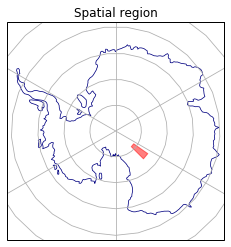

In [3]:
##----------------------------##
##------ Spatial range -------##'
##----------------------------##'
#Return a GeoDataFrame object
if subset_method == 1:
    gdf = gpd.read_file(region_filepath)

#Plot kml region
%matplotlib inline
crs_southpole = ccrs.SouthPolarStereo(central_longitude=0.0, globe=None)
crs_latlon = ccrs.PlateCarree()
plt.figure()
ax = plt.axes(projection=crs_southpole)
ax.coastlines(linewidth=0.75, color='navy')
ax.set_extent((-180, 180, -90, -65), crs=crs_latlon)
ax.gridlines(crs=crs_latlon, linestyle='-')
ax.add_geometries([bbox], crs=crs_latlon, color='red', alpha=0.5)
ax.set_title('Spatial region')
if subset_method == 1:
    if(gdf.crs['init'] == 'epsg:3031'):
        ax.add_geometries(gdf.geometry, crs = crs_southpole, color = 'red', alpha=0.5)
    elif gdf.crs['init'] == 'epsg:4326':
        ax.add_geometries(gdf.geometry, crs = crs_latlon, color = 'red', alpha=0.5)

    #Integer position based indexing of GeoDataFrame object to get it into a shapeply geometry object.
    poly = gdf.iloc[0].geometry
    
if subset_method == 2:
    poly = bbox
# Simplify polygon. The larger the tolerance value, the more simplified the polygon.
poly = poly.simplify(0.05, preserve_topology=False)
# Orient counter-clockwise
poly = orient(poly, sign=1.0)
#Format dictionary to polygon coordinate pairs for CMR polygon filtering
polygon = ','.join([str(c) for xy in zip(*poly.exterior.coords.xy) for c in xy])
print(polygon)
##----------------------------##
##------ Temporal range -------##
##----------------------------##
temporal = start_date + 'T' + start_time + 'Z' + ',' + end_date + 'T' + end_time + 'Z'
timevar = start_date + 'T' + start_time + ',' + end_date + 'T' + end_time #used for subsetting
print(f'Temporal range = {temporal}')

##----------------------------##
##------ Output path -------##
##----------------------------##
if not os.path.exists(path):
    os.mkdir(path)

## 2) Create a token and find granules
#### We will generate a token needed in order to access data using your Earthdata Login credentials, and we will apply that token to the following queries. 

If you get KeyError: 'token', then you typed your password wrong!

In [4]:
# Request token from Common Metadata Repository using Earthdata credentials
token_api_url = 'https://cmr.earthdata.nasa.gov/legacy-services/rest/tokens'
hostname = socket.gethostname()
ip = socket.gethostbyname(hostname)

data = {
    'token': {
        'username': uid,
        'password': pswd,
        'client_id': 'NSIDC_client_id',
        'user_ip_address': ip
    }
}
headers={'Accept': 'application/json'}
response = requests.post(token_api_url, json=data, headers=headers)
token = json.loads(response.content)['token']['id']

#### Find the latest version for ICESat-2 data

In [5]:
# Get json response from CMR collection metadata and print results. This provides high-level metadata on a data set or "collection", provide in json format.
params = {
    'short_name': short_name
}

cmr_collections_url = 'https://cmr.earthdata.nasa.gov/search/collections.json'
response = requests.get(cmr_collections_url, params=params)
results = json.loads(response.content)

# Find all instances of 'version_id' in metadata and print most recent version number

versions = [i['version_id'] for i in results['feed']['entry']]
latest_version = max(versions)
print(f'Latest version = {latest_version}')

Latest version = 001


#### Here we will find the number of granules in selected temporal and spatial region and the size of the granules

In [8]:
params = {
    'short_name': short_name,
    'version': latest_version,
    'temporal': temporal,
    'page_size': 100,
    'page_num': 1,
    'polygon': polygon,
    }


# Query number of granules using our (paging over results)

granule_search_url = 'https://cmr.earthdata.nasa.gov/search/granules'

granules = []
while True:
    response = requests.get(granule_search_url, params=params, headers=headers)
    results = json.loads(response.content)

    if len(results['feed']['entry']) == 0:
        # Out of results, so break out of loop
        break

    # Collect results and increment page_num
    granules.extend(results['feed']['entry'])
    params['page_num'] += 1

# Get number of granules over my area and time of interest
print(f'Number of granules = {len(granules)}')

granule_sizes = [float(granule['granule_size']) for granule in granules]
print(f'Mean size of of granules = {mean(granule_sizes)} MB')
print(f'Total size of of granules = {sum(granule_sizes)} MB')

Number of granules = 2
Mean size of of granules = 93.0070681572 MB
Total size of of granules = 186.0141363144 MB


## 3) Select the subsetting and reformatting services enabled for your data set of interest.

We will start by querying the service capability to gather and select customization options.

In [9]:
# Query service capability URL 
from xml.etree import ElementTree as ET

capability_url = f'https://n5eil02u.ecs.nsidc.org/egi/capabilities/{short_name}.{latest_version}.xml'

# Create session to store cookie and pass credentials to capabilities url

session = requests.session()
s = session.get(capability_url)
response = session.get(s.url,auth=(uid,pswd))

root = ET.fromstring(response.content)

# collect lists with each service option

subagent = [subset_agent.attrib for subset_agent in root.iter('SubsetAgent')]

# variable subsetting
variables = [SubsetVariable.attrib for SubsetVariable in root.iter('SubsetVariable')]  
variables_raw = [variables[i]['value'] for i in range(len(variables))]
variables_join = [''.join(('/',v)) if v.startswith('/') == False else v for v in variables_raw] 
variable_vals = [v.replace(':', '/') for v in variables_join]

# reformatting
formats = [Format.attrib for Format in root.iter('Format')]
format_vals = [formats[i]['value'] for i in range(len(formats))]
format_vals.remove('')

# reprojection only applicable on ICESat-2 L3B products, yet to be available. 

# reformatting options that support reprojection
normalproj = [Projections.attrib for Projections in root.iter('Projections')]
normalproj_vals = []
normalproj_vals.append(normalproj[0]['normalProj'])
format_proj = normalproj_vals[0].split(',')
format_proj.remove('')
format_proj.append('No reformatting')

#reprojection options
projections = [Projection.attrib for Projection in root.iter('Projection')]
proj_vals = []
for i in range(len(projections)):
    if (projections[i]['value']) != 'NO_CHANGE' :
        proj_vals.append(projections[i]['value'])
        
# reformatting options that do not support reprojection
no_proj = [i for i in format_vals if i not in format_proj]

## Request data from the NSIDC data access API.

In [10]:
#Set NSIDC data access base URL
base_url = 'https://n5eil02u.ecs.nsidc.org/egi/request'

# Set number of granules requested per order, which we will initially set to 10.
page_size = 10

#Determine number of pages basd on page_size and total granules. Loop requests by this value
page_num = math.ceil(len(granules)/page_size)

#Set request mode. 
request_mode = 'async'

# Determine how many individual orders we will request based on the number of granules requested

print(f'Number of pages = {page_num}')

#Print API base URL + request parameters
API_request = f'{base_url}?short_name={short_name}&version={latest_version}&temporal={temporal}&time={timevar}&polygon={polygon}&request_mode={request_mode}&page_size={page_size}&page_num={page_num}&token={token}&email={email}'
subset_params = {
    'short_name': short_name, 
    'version': latest_version,
    'temporal': temporal, 
    'time': timevar, 
    'polygon': polygon, 
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }

request_params = {
    'short_name': short_name, 
    'version': latest_version, 
    'temporal': temporal, 
    'polygon': polygon, 
    'agent' : 'NO',
    'include_meta' : 'Y',
    'request_mode': request_mode, 
    'page_size': page_size,  
    'token': token, 
    'email': email, 
    }

Number of pages = 1


In [12]:
# Request data service for each page number, and unzip outputs

for i in range(page_num):
    page_val = i + 1
    print('Order: ', page_val)
    subset_params.update( {'page_num': page_val} )
    
# Post polygon to API endpoint for polygon subsetting to subset based on original, non-simplified KML file
    if subset_method == 1:
        shape_post = {'shapefile': open(kml_filepath, 'rb')}
        request = session.post(base_url, params=subset_params, files=shape_post) 
    if subset_method == 2:
        request = session.get(base_url, params=request_params)
    
    print('Request HTTP response: ', request.status_code)

# Raise bad request: Loop will stop for bad response code.
    request.raise_for_status()
    print('Order request URL: ', request.url)
    esir_root = ET.fromstring(request.content)
    print('Order request response XML content: ', request.content)

# Look up order ID
    orderlist = []   
    for order in esir_root.findall("./order/"):
        orderlist.append(order.text)
    orderID = orderlist[0]
    print('order ID: ', orderID)

# Create status URL
    statusURL = base_url + '/' + orderID
    print('status URL: ', statusURL)

# Find order status
    request_response = session.get(statusURL)    
    print('HTTP response from order response URL: ', request_response.status_code)
    
# Raise bad request: Loop will stop for bad response code.
    request_response.raise_for_status()
    request_root = ET.fromstring(request_response.content)
    statuslist = []
    for status in request_root.findall("./requestStatus/"):
        statuslist.append(status.text)
    status = statuslist[0]
    print('Data request ', page_val, ' is submitting...')
    print('Initial request status is ', status)

# Continue to loop while request is still processing
    while status == 'pending' or status == 'processing': 
        print('Status is not complete. Trying again.')
        time.sleep(10)
        loop_response = session.get(statusURL)

# Raise bad request: Loop will stop for bad response code.
        loop_response.raise_for_status()
        loop_root = ET.fromstring(loop_response.content)

# Find status
        statuslist = []
        for status in loop_root.findall("./requestStatus/"):
            statuslist.append(status.text)
        status = statuslist[0]
        print('Retry request status is: ', status)
        if status == 'pending' or status == 'processing':
            continue

# Order can either complete, complete_with_errors, or fail:
# Provide complete_with_errors error message:
    if status == 'complete_with_errors' or status == 'failed':
        messagelist = []
        for message in loop_root.findall("./processInfo/"):
            messagelist.append(message.text)
        print('error messages:')
        pprint.pprint(messagelist)

# Download zipped order if status is complete or complete_with_errors
    if status == 'complete' or status == 'complete_with_errors':
        downloadURL = 'https://n5eil02u.ecs.nsidc.org/esir/' + orderID + '.zip'
        print('Zip download URL: ', downloadURL)
        print('Beginning download of zipped output...')
        zip_response = session.get(downloadURL)
        # Raise bad request: Loop will stop for bad response code.
        zip_response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(zip_response.content)) as z:
            z.extractall(path)
        print('Data request', page_val, 'is complete.')
    else: print('Request failed.')

Order:  1
Request HTTP response:  201
Order request URL:  https://n5eil02u.ecs.nsidc.org/egi/request?short_name=ATL06&version=001&temporal=2019-02-27T00%3A00%3A00Z%2C2019-02-27T23%3A59%3A59Z&polygon=125.0%2C-81.0%2C125.0%2C-85.0%2C135.0%2C-85.0%2C135.0%2C-81.0%2C125.0%2C-81.0&agent=NO&include_meta=Y&request_mode=async&page_size=10&token=E5D77B82-487D-A9A7-DB67-E688643F04D2&email=devon.dunmire%40colorado.edu
Order request response XML content:  b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n<eesi:agentResponse xsi:schemaLocation="http://eosdis.nasa.gov/esi/rsp/e https://newsroom.gsfc.nasa.gov/esi/8.1/schemas/ESIAgentResponseExternal.xsd" xmlns="" xmlns:iesi="http://eosdis.nasa.gov/esi/rsp/i" xmlns:ssw="http://newsroom.gsfc.nasa.gov/esi/rsp/ssw" xmlns:eesi="http://eosdis.nasa.gov/esi/rsp/e" xmlns:esi="http://eosdis.nasa.gov/esi/rsp" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">\n    <order>\n        <orderId>5000000360817</orderId>\n        <Instructions>You may rece

In [13]:
#Clean up Outputs folder by removing individual granule folders 

for root, dirs, files in os.walk(path, topdown=False):
    for file in files:
        try:
            shutil.move(os.path.join(root, file), path)
        except OSError:
            pass
        
for root, dirs, files in os.walk(path):
    for name in dirs:
        os.rmdir(os.path.join(root, name))
        
#List files
sorted(os.listdir(path))

['ATL06_20190227011129_09250211_001_02.h5',
 'ATL06_20190227011129_09250211_001_02.iso.xml',
 'ATL06_20190227103713_09310211_001_01.h5',
 'ATL06_20190227103713_09310211_001_01.iso.xml',
 'processed_ATL06_20181128115420_09290112_001_01.h5',
 'processed_ATL06_20181128115420_09290112_001_01_gt1l.h5',
 'processed_ATL06_20181128115420_09290112_001_01_gt1r.h5',
 'processed_ATL06_20181128115420_09290112_001_01_gt2l.h5',
 'processed_ATL06_20181128115420_09290112_001_01_gt2r.h5',
 'processed_ATL06_20181128115420_09290112_001_01_gt3l.h5',
 'processed_ATL06_20181128115420_09290112_001_01_gt3r.h5',
 'processed_ATL06_20190227073422_09290212_001_02.h5',
 'processed_ATL06_20190227073422_09290212_001_02_gt1l.h5',
 'processed_ATL06_20190227073422_09290212_001_02_gt1r.h5',
 'processed_ATL06_20190227073422_09290212_001_02_gt2l.h5',
 'processed_ATL06_20190227073422_09290212_001_02_gt2r.h5',
 'processed_ATL06_20190227073422_09290212_001_02_gt3l.h5',
 'processed_ATL06_20190227073422_09290212_001_02_gt3r.h5'

## 4) Separate beams

Here we separate the single granule into separate files for each beam

In [17]:
if short_name == 'ATL03':
    files = list_files_local(path + '*ATL03*1.h5')
elif short_name == 'ATL06':
    files = list_files_local(path + '*ATL06*2.h5')
print(files)

njobs = 1

#NOTE: Using Kamb bounding box for now
bbox = None #[-1124782, 81623, -919821, -96334]

if njobs == 1:
    print('running in serial ...')
    if short_name == 'ATL03':
        [read_atl03(f, bbox) for f in files]
    elif short_name == 'ATL06':
        [read_atl06(f, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    if short_name == 'ATL03':
        Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl03)(f, bbox) for f in files)
    elif short_name == 'ATL06':
        Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, bbox) for f in files)

    
print('Done.')

['/Volumes/c3po/Research/ICESat2/data/RBIS/ATL06_20190227011129_09250211_001_02.h5', '/Volumes/c3po/Research/ICESat2/data/RBIS/processed_ATL06_20190227073422_09290212_001_02.h5']
running in serial ...
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/ATL06_20190227011129_09250211_001_02_gt1l.h5
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/ATL06_20190227011129_09250211_001_02_gt1r.h5
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/ATL06_20190227011129_09250211_001_02_gt2l.h5
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/ATL06_20190227011129_09250211_001_02_gt2r.h5
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/ATL06_20190227011129_09250211_001_02_gt3l.h5
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/ATL06_20190227011129_09250211_001_02_gt3r.h5
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/processed_ATL06_20190227073422_09290212_001_02_gt1l.h5
out -> /Volumes/c3po/Research/ICESat2/data/RBIS/processed_ATL06_20190227073422_09290212_001_02_gt1r.h5
out -> /Volumes/c3po/Research/ICESa

##----------------------------##
##------ Coverage -------##
##----------------------------##
print('dataset = ', short_name)
if short_name == 'ATL03':
    coverage = '/gt1l/heights/lat_ph,\
/gt1l/heights/lon_ph,\
/gt1l/heights/h_ph,\
/gt1l/heights/signal_conf_ph,\
/gt1r/heights/lat_ph,\
/gt1r/heights/lon_ph,\
/gt1r/heights/h_ph,\
/gt1r/heights/signal_conf_ph,\
/gt2l/heights/lat_ph,\
/gt2l/heights/lon_ph,\
/gt2l/heights/h_ph,\
/gt2l/heights/signal_conf_ph,\
/gt2r/heights/lat_ph,\
/gt2r/heights/lon_ph,\
/gt2r/heights/h_ph,\
/gt2r/heights/signal_conf_ph,\
/gt3l/heights/lat_ph,\
/gt3l/heights/lon_ph,\
/gt3l/heights/h_ph,\
/gt3l/heights/signal_conf_ph,\
/gt3r/heights/lat_ph,\
/gt3r/heights/lon_ph,\
/gt3r/heights/h_ph,\
/gt3r/heights/signal_conf_ph'

elif short_name == 'ATL06':
    coverage = '/ancillary_data/atlas_sdp_gps_epoch,\
    /gt1l/land_ice_segments/atl06_quality_summary,\
    /gt1l/land_ice_segments/delta_time,\
    /gt1l/land_ice_segments/h_li,\
    /gt1l/land_ice_segments/h_li_sigma,\
    /gt1l/land_ice_segments/latitude,\
    /gt1l/land_ice_segments/longitude,\
    /gt1l/land_ice_segments/segment_id,\
    /gt1l/land_ice_segments/sigma_geo_h,\
    /gt1r/land_ice_segments/atl06_quality_summary,\
    /gt1r/land_ice_segments/delta_time,\
    /gt1r/land_ice_segments/h_li,\
    /gt1r/land_ice_segments/h_li_sigma,\
    /gt1r/land_ice_segments/latitude,\
    /gt1r/land_ice_segments/longitude,\
    /gt1r/land_ice_segments/segment_id,\
    /gt1r/land_ice_segments/sigma_geo_h,\
    /gt2l/land_ice_segments/atl06_quality_summary,\
    /gt2l/land_ice_segments/delta_time,\
    /gt2l/land_ice_segments/h_li,\
    /gt2l/land_ice_segments/h_li_sigma,\
    /gt2l/land_ice_segments/latitude,\
    /gt2l/land_ice_segments/longitude,\
    /gt2l/land_ice_segments/segment_id,\
    /gt2l/land_ice_segments/sigma_geo_h,\
    /gt2r/land_ice_segments/atl06_quality_summary,\
    /gt2r/land_ice_segments/delta_time,\
    /gt2r/land_ice_segments/h_li,\
    /gt2r/land_ice_segments/h_li_sigma,\
    /gt2r/land_ice_segments/latitude,\
    /gt2r/land_ice_segments/longitude,\
    /gt2r/land_ice_segments/segment_id,\
    /gt2r/land_ice_segments/sigma_geo_h,\
    /gt3l/land_ice_segments/atl06_quality_summary,\
    /gt3l/land_ice_segments/delta_time,\
    /gt3l/land_ice_segments/h_li,\
    /gt3l/land_ice_segments/h_li_sigma,\
    /gt3l/land_ice_segments/latitude,\
    /gt3l/land_ice_segments/longitude,\
    /gt3l/land_ice_segments/segment_id,\
    /gt3l/land_ice_segments/sigma_geo_h,\
    /gt3r/land_ice_segments/atl06_quality_summary,\
    /gt3r/land_ice_segments/delta_time,\
    /gt3r/land_ice_segments/h_li,\
    /gt3r/land_ice_segments/h_li_sigma,\
    /gt3r/land_ice_segments/latitude,\
    /gt3r/land_ice_segments/longitude,\
    /gt3r/land_ice_segments/segment_id,\
    /gt3r/land_ice_segments/sigma_geo_h,\
    /orbit_info/cycle_number,\
    /orbit_info/rgt,\
    /orbit_info/orbit_number'